
# 🌼 제너레이티브AI의 이해 - 1차시(24.11.18)

---


## 1. VAE(Variational Auto Encoder)
- 모델이 숫자 이미지를 압축하고, 복원하는 과정(인코더-디코더)
- 인코더 : 입력 이미지를 잠재공간으로 매핑
- 디코더 : 잠재 공간에서 샘플을 받아 이미지 복원
- 가상환경 실행 후 - pip install opencv-python로 설치!

### Tensorflow를 활용한 celeb데이터셋에 VAE 적용하기

In [86]:
import os
import tensorflow as tf
from tensorflow import keras
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [87]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("yunting0123/img-align-celeba")

print("Path to dataset files:", path)

c:\Users\RMARKET\anaconda3\envs\tensor_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: C:\Users\RMARKET\.cache\kagglehub\datasets\yunting0123\img-align-celeba\versions\1


In [88]:
# 데이터 경로 설정
image_dir = "C:/Users/RMARKET/.cache/kagglehub/datasets/yunting0123/img-align-celeba/versions/1/t/celebA"

In [89]:
img_filenames = os.listdir(image_dir)[-1]
img_filenames

'030000.png'

In [90]:
# 1. 이미지 불러오고 전처리 하는 함수 만들기
def load_preprocess_images(image_dir, img_size = (128, 128), num_images = 10000):
    # 경로, 이미지 크기, 최대 로드할 이미지 개수
    images = []
    # 전처리 된 이미지를 추가할 리스트
    img_filenames = os.listdir(image_dir)[:num_images]
    for filename in img_filenames:
        img_path = os.path.join(image_dir, filename)
        # 이미지 파일의 전체 경로를 image_dir(파일 경로) + filename(파일 이름)으로 만들어 주기
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, img_size)
            img = img / 255.0 # 이미지 정규화
            # 정규화 과정
            # rgb [204, 76, 128] -> [0.8, 0.3, 0.5]
            images.append(img)
    return np.array(images)


In [91]:
images = load_preprocess_images(image_dir)
images

array([[[[0.75294118, 0.90588235, 0.99215686],
         [0.75294118, 0.90588235, 0.99215686],
         [0.75294118, 0.90588235, 0.99215686],
         ...,
         [0.78823529, 0.88627451, 0.94901961],
         [0.84705882, 0.92156863, 0.96862745],
         [0.87843137, 0.9372549 , 0.98039216]],

        [[0.75294118, 0.90588235, 0.99215686],
         [0.75294118, 0.90588235, 0.99215686],
         [0.75294118, 0.90588235, 0.99215686],
         ...,
         [0.79607843, 0.89411765, 0.95294118],
         [0.85098039, 0.92156863, 0.97254902],
         [0.87843137, 0.9372549 , 0.98039216]],

        [[0.75294118, 0.90588235, 0.99215686],
         [0.75294118, 0.90588235, 0.99215686],
         [0.75294118, 0.90588235, 0.99215686],
         ...,
         [0.81960784, 0.90588235, 0.96078431],
         [0.85490196, 0.9254902 , 0.97647059],
         [0.8745098 , 0.93333333, 0.98431373]],

        ...,

        [[0.23529412, 0.40392157, 0.6745098 ],
         [0.22745098, 0.39215686, 0.6627451 ]

In [92]:
# 2. 샘플링 함수 정의
# 잠재공간에서 새로운 샘플을 생성하기 위해 데이터포이트들을 샘플링하는 과정
# 각 데이터포인터들의 평균값과 로그 분산을 출력하는 함수
def sampling(z_mean, z_log_var):
    # 모델이 새로운 데이터포인트(z)를 생성할 수 있음
    batch = tf.shape(z_mean)[0]
    # 딥러닝프레임워크는 데이터 입력시 자동으로 배치 크기를 감지
    # 0번째 자리의 값이 batch 사이즈이므로 batch라는 이름의 변수로 저장한 것

    dim = tf.shape(z_mean)[1]
    # 잠재공간의 차원값

    epsilon = tf.random.normal(shape = (batch, dim))
    # 배치사이즈와 차원의 shape을 갖는 표준정규분포의 무작위값 생성

    return z_mean + tf.exp(0.5 * z_log_var) * epsilon
# tf.exp(0.5 z_log_var) -> 로그 분산을 표준편차로 변환하는 과정, 로그분산에 0.5를 곱하고 지수함수를 적용 -> 표준편차를 구함

In [93]:
# 3. 인코더 정의
latent_dim = 200
# 잠재공간의 차원
# 간단한 데이터나 테스트목적 : 2 ~ 10 정도
# 복잡한 이미지나 고차원 : 100 ~ 200 사용

encoder_input = keras.layers.Input(shape = (128, 128, 3), name='encoder_input') # shape = (가로, 세로, 차원(컬러(rgb)))
# 128x128 사이즈의 컬러 이미지를 인풋으로 넣을 것임을 명시적으로 지정한 것
x = keras.layers.Conv2D(32, (3,3), strides = 2, activation = 'relu', padding = 'same')(encoder_input) # padding = 'same' : 가장자리에 패딩이 들어가기 위해(입력과 출력값이 같게 하기 위해)
# Conv2D : 공간적인 패턴 학습 가능
# 32개 필터, (3,3)커널, 슬라이딩 간격 2
x = keras.layers.Conv2D(64, (3, 3), strides = 2, activation = 'relu', padding='same')(x)
x = keras.layers.Conv2D(128,  (3,3), strides = 2, activation= 'relu', padding='same')(x)
# 텐서 : 딥러닝 적인 연산이 가능하다
# x.sahpe = (batch_size, height, width, channels)
shape_before_flattening = x.shape[1:]
# x를 1차원 벡터로 변환하기 전 정보 저장

# 1차원 벡터로 변환 : Conv2D는 이미지의 공간적인 구조를 학습할 수 있으나 결정을 내릴 순 없음
# 결정을 내릴 수 있는 Dense층을 쌓아주기 위해 1차원 벡터로 변환(flatten, 평탄화)
x = keras.layers.Flatten()(x)

# 인코더의 마지막 단계
z_mean = keras.layers.Dense(latent_dim, name = 'z_mean')(x)
z_log_var = keras.layers.Dense(latent_dim, name = 'z_log_var')(x)
# 두 레이어는 동일한 입력 x를 받지만, 손실함수와 역전파 과정에 의해 다른 출력을 학습

z = sampling(z_mean, z_log_var)
# 무작위 벡터값 생성

encoder = keras.models.Model(encoder_input, [z_mean, z_log_var, z], name = 'encoder')
# 모델은 3개의 출력을 반환한다
# z_mean : 인코더가 학습한 잠재 공간의 평균 벡터
# z_log_var : 인코더가 학습한 로그 분산 벡터
# z : 평균과 분산을 사용해 샘플링된 잠재 공간의 벡터


In [94]:
# 4. 디코더 정의
decoder_input = keras.layers.Input(shape = (latent_dim,), name='decoder_input')
x = keras.layers.Dense(np.prod(shape_before_flattening))(decoder_input)
# Dense 레이어로 잠재공간의 벡터를 디코더 출력에 맞게 변환
# prod : 이 형태의 모든 차원을 곱해 1차원 값으로 변환
# (16,16,128) -> 16x16x128
# 먼저 위에서 저장했던 flatten전 마지막 3차원을 1차원으로 변환 후 Dense레이어에 적용

x = keras.layers.Reshape(shape_before_flattening)(x)
# 원래 인코더의 마지막 출력 형태인 3차원 텐서로 다시 reshape
x = keras.layers.Conv2DTranspose(128, (3,3), strides = 2, activation = 'relu', padding='same')(x)
x = keras.layers.Conv2DTranspose(64, (3,3), strides = 2, activation = 'relu', padding='same')(x)
x = keras.layers.Conv2DTranspose(32, (3,3), strides = 2, activation = 'relu', padding='same')(x)

decoder_output = keras.layers.Conv2D(3, (3,3), strides = 1, activation = 'sigmoid', padding='same', name='decoder_output')(x)
decoder = keras.models.Model(decoder_input, decoder_output, name = 'decoder')

In [95]:
optimizer = keras.optimizers.Adam()

In [96]:
# 5. 학습 루프 만들기
def train_step(data):
    with tf. GradientTape() as tape:
        # with tf. GradientTape() : tensorflow에서 자동 미분을 위해 설저하는 with문
        z_mean, z_log_var, z = encoder(data)
        recon = decoder(z)
        # recon : 재구성된 이미지 / 입력데이터와 비교될 이미지
        recon_loss = tf.reduce_mean(500 * tf.losses.binary_crossentropy(data,recon))
        # 원본 데이터와 재구성된 이미지 데이터 간의 차이를
        # 픽셀의 이진분포롤 계산
        # 가중치를 500 곱해서 조정
        # reduce_mean : 배치 내 모든 데이터포인트의 평균손실을 계산한다는 의미

        # 2. KL-발산 손실
        kl_loss = tf.reduce_mean(tf.reduce_sum(-0.5 * (1 + z_log_var - tf.square(z_mean)-tf.exp(z_log_var)), axis = 1)) 
        # KL 발산의 공식 : (1 + z_log_var - tf.square(z_mean)-tf.exp(z_log_var))
        # axis = 1옵션을 넣었기 때문에 각 차원에 대한 합산이 이루어 짐
        total_loss = recon_loss + kl_loss
    grad = tape.gradient(total_loss, encoder.trainable_weights + decoder.trainable_weights) # trainable_weights : 가중치
    optimizer.apply_gradients(zip(grad, encoder.trainable_weights + decoder.trainable_weights)) # 각각의 가중치를 업데이트
    # 계산된 기울기를 사용하여 Adam최적화 알고리즘을 통해 인코더와 디코더의 가중치를 업데이트
    return total_loss, recon_loss, kl_loss
    # 총 손실, 재구성 손실, KL-발산 손실을 반환
        

In [97]:
batch_size = 32
epochs = 10
dataset = tf.data.Dataset.from_tensor_slices(images).shuffle(1000).batch(batch_size)
# tf.data.Dataset.from_tensor_slices : 주어진 텐서를 받아 이를 개별 슬라이스로 나눠 데이터셋을 생성

In [98]:
for epoch in range(epochs):
    print(f'Epoch {epoch + 1} / {epochs}')
    for step, batch_data in enumerate(dataset):
        # 현재 스텝과 배치데이터를 반환
        total_loss, recon_loss, kl_loss = train_step(batch_data)
        if step % 100 == 0:
            # 스텝이 100의 배수일 때 마다(loss 값이 크면 정확도가 낮다)
            print(f'step{step} : total loss = {total_loss.numpy():.4f},'
                  f'recon loss : {recon_loss.numpy():.4f},'
                  f'KL loss : {kl_loss.numpy():.4f}')

Epoch 1 / 10
step0 : total loss = 347.3020,recon loss : 346.6640,KL loss : 0.6380
step100 : total loss = 303.7455,recon loss : 294.0172,KL loss : 9.7283
step200 : total loss = 299.4582,recon loss : 290.7581,KL loss : 8.7001
step300 : total loss = 306.5897,recon loss : 297.8869,KL loss : 8.7028
Epoch 2 / 10
step0 : total loss = 295.9629,recon loss : 285.5273,KL loss : 10.4357
step100 : total loss = 305.9063,recon loss : 295.7710,KL loss : 10.1353
step200 : total loss = 294.5068,recon loss : 283.5233,KL loss : 10.9834
step300 : total loss = 301.6463,recon loss : 290.2564,KL loss : 11.3900
Epoch 3 / 10
step0 : total loss = 302.4252,recon loss : 292.0306,KL loss : 10.3945
step100 : total loss = 291.4124,recon loss : 279.6762,KL loss : 11.7362
step200 : total loss = 291.7481,recon loss : 278.7220,KL loss : 13.0261
step300 : total loss = 298.7568,recon loss : 287.5798,KL loss : 11.1770
Epoch 4 / 10
step0 : total loss = 300.1243,recon loss : 289.2360,KL loss : 10.8883
step100 : total loss = 3

In [99]:
import matplotlib.pyplot as plt

def generate_images(original_images, num_images=5):
    selected = np.random.choice(len(original_images), num_images, replace=False)
    sampled_originals = original_images[selected]

    z_mean, z_log_var, z = encoder.predict(sampled_originals)
    generated_images = decoder.predict(z)

    plt.figure(figsize = (15, 5))
    for i in range(num_images):
        plt.subplot(2,num_images, i+1)
        plt.imshow(sampled_originals[i])
        plt.title('original')
        plt.axis('off')
        # 원본 이미지

        plt.subplot(2, num_images, num_images + i + 1)
        plt.imshow(generated_images[i])
        plt.title('reconstructed')
        plt.axis('off')
    plt.show()
        

1/1 [==============================] - 0s 379ms/step


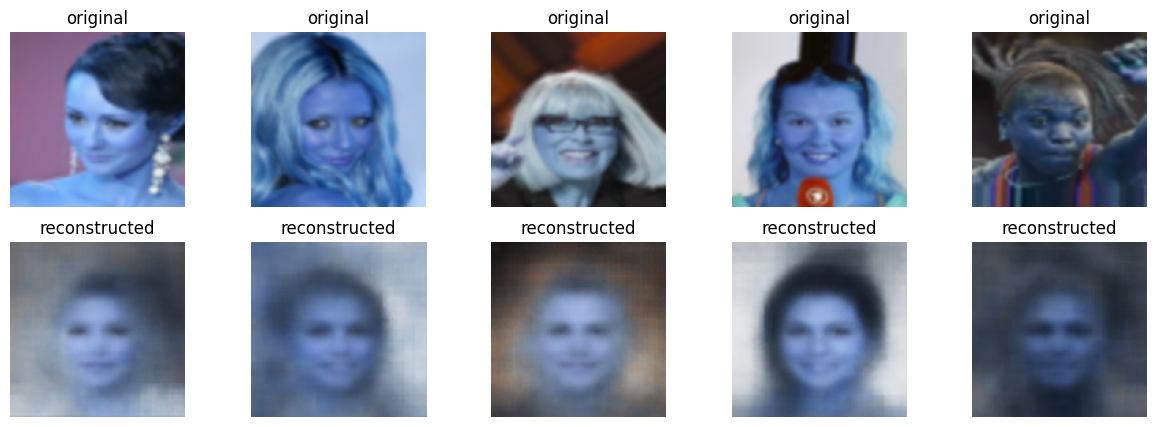

In [100]:
generate_images(images)

In [101]:
encoder.save('vae_encoder.h5')
decoder.save('vae_encoder.h5')

In [102]:
load_encoder = keras.models.load_model('vae_encoder.h5', compile=False)
# compile : 기본 값 True -> 옵티마이저 손실함수 추가 설정 가능

---
### Torch를 활용한 MNIST데이터셋에 VAE 적용하기

In [103]:
# pip install torch torchvision matplotlib

In [104]:
# 손글씨
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [105]:
# transform = transforms.Compose({
#     transforms.ToTensor(),
#     transforms.Normalize((0.5,),(0.5,)) # 데이터 정규화
# })
# minst_data = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
# data_loader = DataLoader(minst_data, batch_size=64, shuffle=True)

In [106]:
transform = transforms.ToTensor()
minst_data = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
data_loader = DataLoader(minst_data, batch_size=64, shuffle=True)

In [107]:
sample_image, sample_label = next(iter(data_loader))

In [108]:
sample_label

tensor([9, 2, 4, 9, 0, 6, 6, 4, 6, 1, 5, 3, 0, 3, 4, 9, 6, 7, 4, 6, 9, 1, 9, 4,
        1, 6, 9, 0, 2, 1, 7, 0, 1, 5, 8, 7, 4, 8, 4, 9, 5, 4, 7, 9, 7, 4, 3, 1,
        4, 2, 9, 9, 0, 4, 8, 3, 9, 7, 6, 5, 5, 5, 5, 4])

In [109]:
print(f'첫번째 데이터의 shape :{sample_image.shape}')
# 배치크기, 채널, 높이, 너비

첫번째 데이터의 shape :torch.Size([64, 1, 28, 28])


In [110]:
sample_image[1].shape

torch.Size([1, 28, 28])

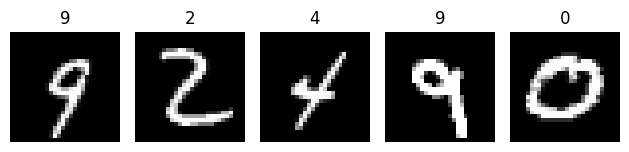

In [111]:
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(sample_image[i].squeeze(), cmap='gray')
    # squeeze : 차원이 1인 축을 제거하는 메서드
    plt.title(sample_label[i].item())
    plt.axis('off')
plt.tight_layout()
plt.show()

In [112]:
image_size = 28 * 28
# 784 : 1차원으로 변환하기 위한 이미지 사이즈
latent_size = 10
W_enc = torch.randn(image_size, latent_size, requires_grad = True)
# (784, 10) / 인코더 가중치
b_enc = torch.zeros(latent_size, requires_grad=True)
# 편향을 0으로 초기화 /인코더 편향 (균형을 잡아주는 역할)
# 입력이 0이면 -> 출력도 0 / 그것의 균형을 잡아주는게 편향



In [113]:
# 인코더 함수정의
def encoder(x):
    x = x.view(-1, image_size)
    # view : 텐서를 특정 형태로 변환
    z_mean = torch.matmul(x, W_enc) + b_enc
    z_logvar = torch.matmul(x, W_enc) + b_enc
    return z_mean, z_logvar

In [114]:
# 샘플링 함수 정의
def sample(mean, logvar):
    std = torch.exp(0.5 * logvar)
    # std = 표준편차
    epsilon = torch.randn_like(std)
    # randn_like(x) -> x와 비슷한 형태로 랜덤한 값을 생성
    # 평균이 0이고 표준편차가 1인 정규분포에서 epsilon 샘플링
    return mean + std * epsilon
# 샘플링 된 잠재 벡터 값 계산

In [115]:
W_dec = torch.randn(latent_size, image_size, requires_grad=True)
# 디코더 가중치
b_dec = torch.zeros(image_size, requires_grad=True)
# 디코더 편향

In [116]:
def decoder(z):
    x_hat = torch.matmul(z, W_dec) + b_dec
    return torch.sigmoid(x_hat)
    # 0과 1사이의 값으로 반환

In [117]:
# 손실함수 구성
def loss_function(x, x_hat, mean, logvar):
    recons_loss = ((x.view(-1, image_size) - x_hat.view(-1, image_size))**2).mean() # 제곱하여 mse 를 계산하고 평균
    kl_loss = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())
    return recons_loss + kl_loss

In [118]:
# 최적화 함수 설정
optimizer = torch.optim.Adam([W_enc, b_enc, W_dec, b_dec])

In [119]:
epochs = 20
for epoch in range (epochs):
    for images, _ in data_loader:
        mean, logvar = encoder(images)
        z = sample(mean, logvar)
        x_hat = decoder(z)
        loss = loss_function(images, x_hat, mean, logvar)
        # ---초기화 
        optimizer.zero_grad()
        # 기울기 초기화
        loss.backward()
        # 역전파를 통해 가중치를 계산
        optimizer.step()
        # 계산된 가중치, 기울기를 업데이트
    print(f'Epoch {epoch+1}, Loss : {loss.item()}')
print('학습완료!!!')

Epoch 1, Loss : 6400787.5
Epoch 2, Loss : 363559072.0
Epoch 3, Loss : 4420408.0
Epoch 4, Loss : 5411688.0
Epoch 5, Loss : 48758604.0
Epoch 6, Loss : 1468723.625
Epoch 7, Loss : 1208073.375
Epoch 8, Loss : 82889.4609375
Epoch 9, Loss : 39445.93359375
Epoch 10, Loss : 24652.8046875
Epoch 11, Loss : 3334582.75
Epoch 12, Loss : 76768.21875
Epoch 13, Loss : 160420.1875
Epoch 14, Loss : 68728.71875
Epoch 15, Loss : 87006.8046875
Epoch 16, Loss : 15576.4677734375
Epoch 17, Loss : 9784.095703125
Epoch 18, Loss : 8480.55078125
Epoch 19, Loss : 7737.46826171875
Epoch 20, Loss : 19363.8515625
학습완료!!!


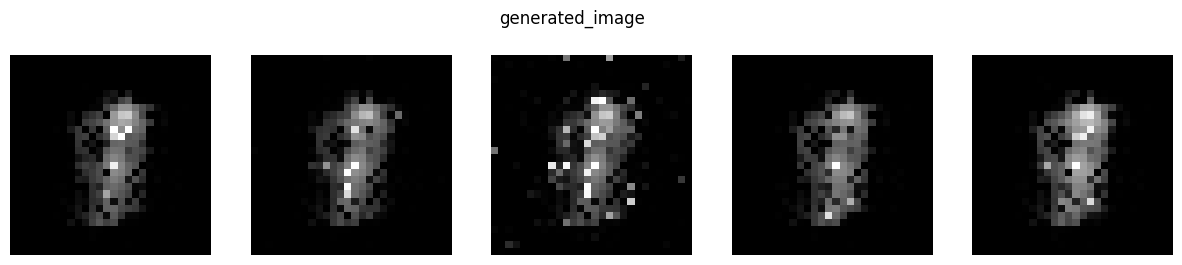

In [120]:
with torch.no_grad():
    count = 5
    z_random = torch.randn(count, latent_size)
    # 잠재 공간에서 무작위로 벡터 샘플링
    generated_image = decoder(z_random).view(count, 28, 28)
    plt.figure(figsize=(15,3))
    for i in range(count):
        plt.subplot(1, count, i + 1)
        plt.imshow(generated_image[i], cmap = 'gray')
        plt.axis('off')
    plt.suptitle('generated_image')
    plt.show()


## 🌼마무리 문제

다양한 데이터셋을 적용해보세요

Q1. Fashion MNIST
- 28X28 크기의 패션 아이템 이미지로 구성된 흑백 이미지 데이터셋


Q2. CIFAR-10
- 32X32 크기의 색상이 있는 자동차, 동물 등 다양한 객체가 포함된 데이터셋

In [121]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Fashion MNIST 데이터셋 로드 (28x28 크기의 패션 아이템 이미지)
trans = transforms.ToTensor()
fashion_mnist_data = datasets.FashionMNIST(root='./data', train=True, transform=trans, download=True)
data_loader = DataLoader(fashion_mnist_data, batch_size=64, shuffle=True)



In [122]:
sample_image, sample_label = next(iter(data_loader))
sample_label

tensor([0, 4, 9, 9, 2, 0, 2, 8, 6, 3, 0, 8, 2, 8, 5, 1, 8, 8, 6, 9, 8, 9, 9, 4,
        7, 9, 1, 2, 8, 2, 0, 7, 1, 9, 4, 6, 3, 9, 6, 2, 8, 8, 4, 0, 3, 6, 0, 9,
        4, 9, 0, 6, 8, 6, 2, 4, 6, 9, 6, 1, 2, 9, 9, 8])

In [123]:
print(f'첫번째 데이터의 shape :{sample_image.shape}')
# 배치크기, 채널, 높이, 너비

첫번째 데이터의 shape :torch.Size([64, 1, 28, 28])


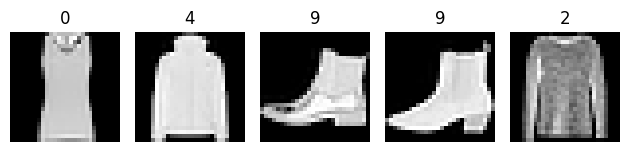

In [124]:
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(sample_image[i].squeeze(), cmap='gray')
    # squeeze : 차원이 1인 축을 제거하는 메서드
    plt.title(sample_label[i].item())
    plt.axis('off')
plt.tight_layout()
plt.show()

In [125]:
image_size = 28 * 28
# 784 : 1차원으로 변환하기 위한 이미지 사이즈
latent_size = 10
W_enc = torch.randn(image_size, latent_size, requires_grad = True)
# (784, 10) / 인코더 가중치
b_enc = torch.zeros(latent_size, requires_grad=True)
# 편향을 0으로 초기화 /인코더 편향 (균형을 잡아주는 역할)
# 입력이 0이면 -> 출력도 0 / 그것의 균형을 잡아주는게 편향

# 샘플링 함수 정의
def sample(mean, logvar):
    std = torch.exp(0.5 * logvar)
    # std = 표준편차
    epsilon = torch.randn_like(std)
    # randn_like(x) -> x와 비슷한 형태로 랜덤한 값을 생성
    # 평균이 0이고 표준편차가 1인 정규분포에서 epsilon 샘플링
    return mean + std * epsilon
# 샘플링 된 잠재 벡터 값 계산

W_dec = torch.randn(latent_size, image_size, requires_grad=True)
# 디코더 가중치
b_dec = torch.zeros(image_size, requires_grad=True)
# 디코더 편향

def decoder(z):
    x_hat = torch.matmul(z, W_dec) + b_dec
    return torch.sigmoid(x_hat)
    # 0과 1사이의 값으로 반환

# 손실함수 구성
def loss_function(x, x_hat, mean, logvar):
    recons_loss = ((x.view(-1, image_size) - x_hat.view(-1, image_size))**2).mean() # 제곱하여 mse 를 계산하고 평균
    kl_loss = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())
    return recons_loss + kl_loss

epochs = 20
for epoch in range (epochs):
    for images, _ in data_loader:
        mean, logvar = encoder(images)
        z = sample(mean, logvar)
        x_hat = decoder(z)
        loss = loss_function(images, x_hat, mean, logvar)
        # ---초기화 
        optimizer.zero_grad()
        # 기울기 초기화
        loss.backward()
        # 역전파를 통해 가중치를 계산
        optimizer.step()
        # 계산된 가중치, 기울기를 업데이트
    print(f'Epoch {epoch+1}, Loss : {loss.item()}')
print('학습완료!!!')

Epoch 1, Loss : 194759855439872.0
Epoch 2, Loss : 3.893906256376627e+16
Epoch 3, Loss : 1811217907712000.0
Epoch 4, Loss : 1.9834809660473344e+16
Epoch 5, Loss : 1.8899515677763174e+17
Epoch 6, Loss : 1.676385328300032e+16
Epoch 7, Loss : 255206587629568.0
Epoch 8, Loss : 2.795512608587776e+16
Epoch 9, Loss : 1.875295249576755e+16
Epoch 10, Loss : 8269557412134912.0
Epoch 11, Loss : 2069310814027776.0
Epoch 12, Loss : 6.732503829394227e+16
Epoch 13, Loss : 622826428039168.0
Epoch 14, Loss : 82353657479168.0
Epoch 15, Loss : 1.2318032175625667e+19
Epoch 16, Loss : 2526136017879040.0
Epoch 17, Loss : 113792675479552.0
Epoch 18, Loss : 22890758012928.0
Epoch 19, Loss : 447518882136064.0
Epoch 20, Loss : 1.1000625861807309e+17
학습완료!!!


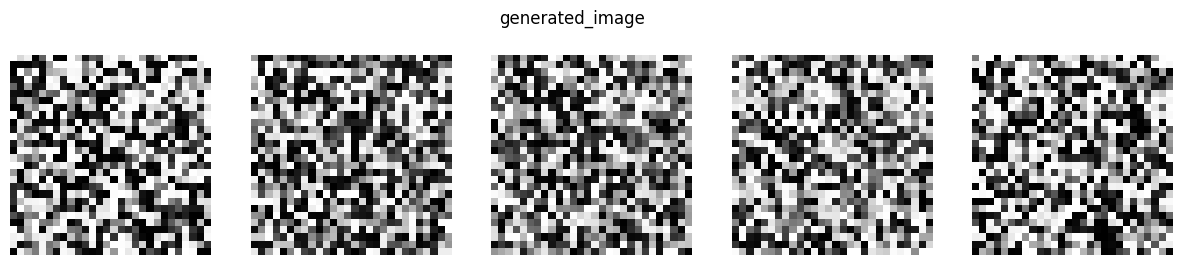

In [126]:
with torch.no_grad():
    count = 5
    z_random = torch.randn(count, latent_size)
    # 잠재 공간에서 무작위로 벡터 샘플링
    generated_image = decoder(z_random).view(count, 28, 28)
    plt.figure(figsize=(15,3))
    for i in range(count):
        plt.subplot(1, count, i + 1)
        plt.imshow(generated_image[i], cmap = 'gray')
        plt.axis('off')
    plt.suptitle('generated_image')
    plt.show()

In [127]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# CIFAR-10 데이터셋 로드 (32x32 크기의 컬러 이미지)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # 데이터 정규화
])
cifar10_data = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
data_loader = DataLoader(cifar10_data, batch_size=64, shuffle=True)


100%|██████████| 170M/170M [00:11<00:00, 14.2MB/s] 


Extracting ./data\cifar-10-python.tar.gz to ./data
